In [1]:
!pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [90]:
import math
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib

from sklearn.tree import export_graphviz
import graphviz

from scipy import stats


# Load Data

In [3]:
df = pd.read_csv('boston_housing.csv')
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


# EDA

## Statistical Analysis

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
crim,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
zn,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
indus,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
chas,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
nox,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
rm,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
age,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
dis,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
rad,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
tax,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


## Histogram

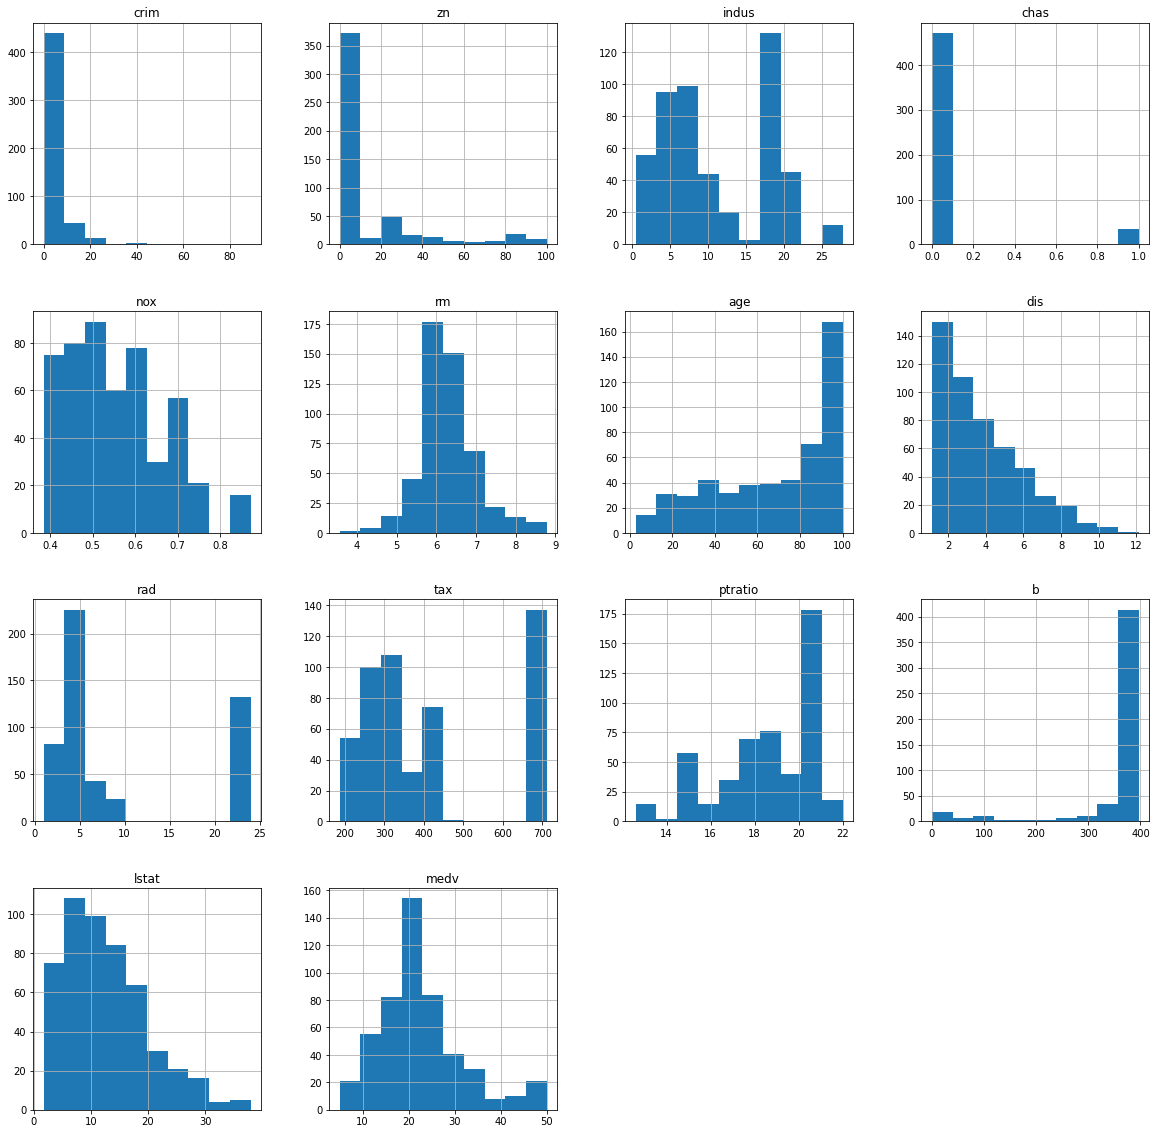

In [6]:
plot = df.hist(figsize = (20,20))

### Pairplot

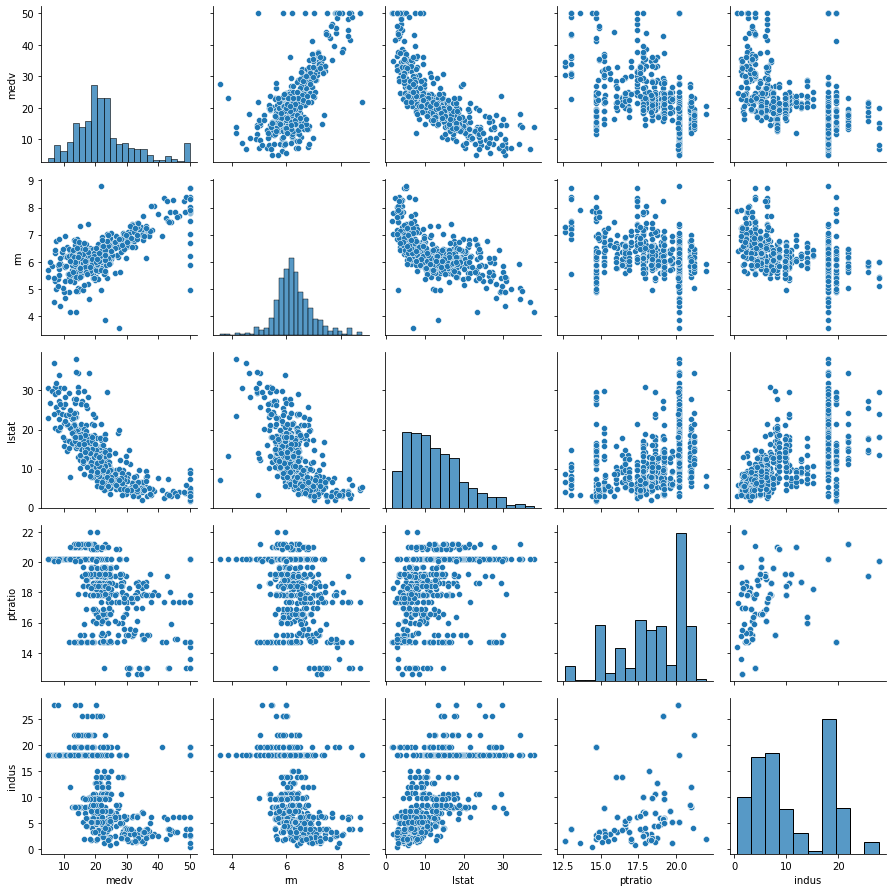

In [105]:
# Calculate and show pairplot
sns.pairplot(df[['medv', 'rm','lstat','ptratio','indus']], size=2.5)
plt.tight_layout()

## Correlation Heatmap

<Axes: >

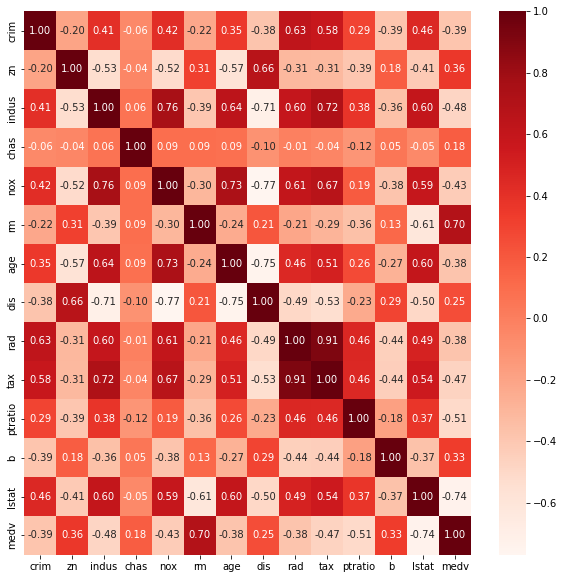

In [7]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), cmap="Reds", annot=True, fmt=".2f")

In [8]:
df[df.columns[0:]].corr()['medv'][:].sort_values()

lstat     -0.737663
ptratio   -0.507787
indus     -0.483725
tax       -0.468536
nox       -0.427321
crim      -0.388305
rad       -0.381626
age       -0.376955
chas       0.175260
dis        0.249929
b          0.333461
zn         0.360445
rm         0.695360
medv       1.000000
Name: medv, dtype: float64

# Data Preparation

## Check Duplication

In [9]:
print(df.duplicated().sum())

0


## Outliers

In [10]:
z = np.abs(stats.zscore(df))
print(z)

         crim        zn     indus      chas       nox        rm       age  \
0    0.419782  0.284830  1.287909  0.272599  0.144217  0.413672  0.120013   
1    0.417339  0.487722  0.593381  0.272599  0.740262  0.194274  0.367166   
2    0.417342  0.487722  0.593381  0.272599  0.740262  1.282714  0.265812   
3    0.416750  0.487722  1.306878  0.272599  0.835284  1.016303  0.809889   
4    0.412482  0.487722  1.306878  0.272599  0.835284  1.228577  0.511180   
..        ...       ...       ...       ...       ...       ...       ...   
501  0.413229  0.487722  0.115738  0.272599  0.158124  0.439316  0.018673   
502  0.415249  0.487722  0.115738  0.272599  0.158124  0.234548  0.288933   
503  0.413447  0.487722  0.115738  0.272599  0.158124  0.984960  0.797449   
504  0.407764  0.487722  0.115738  0.272599  0.158124  0.725672  0.736996   
505  0.415000  0.487722  0.115738  0.272599  0.158124  0.362767  0.434732   

          dis       rad       tax   ptratio         b     lstat      medv  

In [11]:
threshold = 3
print(np.where(z > 3))

(array([ 55,  56,  57, 102, 141, 142, 152, 154, 155, 160, 162, 163, 199,
       200, 201, 202, 203, 204, 208, 209, 210, 211, 212, 216, 218, 219,
       220, 221, 222, 225, 234, 236, 256, 257, 262, 269, 273, 274, 276,
       277, 282, 283, 283, 284, 347, 351, 352, 353, 353, 354, 355, 356,
       357, 358, 363, 364, 364, 365, 367, 369, 370, 372, 373, 374, 374,
       380, 398, 404, 405, 406, 410, 410, 411, 412, 412, 414, 414, 415,
       416, 418, 418, 419, 423, 424, 425, 426, 427, 427, 429, 431, 436,
       437, 438, 445, 450, 454, 455, 456, 457, 466]), array([ 1,  1,  1, 11, 12,  3,  3,  3,  3,  3,  3,  3,  1,  1,  1,  1,  1,
        1,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  5,  3,  3,  1,  5,
        5,  3,  3,  3,  3,  3,  3,  1,  3,  1,  1,  7,  7,  1,  7,  7,  7,
        3,  3,  3,  3,  3,  5,  5,  5,  3,  3,  3, 12,  5, 12,  0,  0,  0,
        0,  5,  0, 11, 11, 11, 12,  0, 12, 11, 11,  0, 11, 11, 11, 11, 11,
       11,  0, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]

In [12]:
df_boston = df[(z < 3).all(axis=1)]
df_boston.shape

(415, 14)

In [13]:
df.shape

(506, 14)

In [14]:
df_boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [15]:
df_boston.describe().T

,count,mean,std,min,25%,50%,75%,max
crim,415.0,2.452461,4.897241,0.00632,0.081005,0.21161,2.152115,28.6558
zn,415.0,9.602410,19.677404,0.00000,0.000000,0.00000,12.500000,80.0000
indus,415.0,10.829687,6.798613,0.46000,5.130000,8.56000,18.100000,27.7400
chas,415.0,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0000
nox,415.0,0.547168,0.110428,0.38500,0.449000,0.52400,0.609000,0.8710
rm,415.0,6.267554,0.611602,4.36800,5.886000,6.19300,6.559500,8.3370
age,415.0,67.384337,28.072043,2.90000,43.550000,73.90000,93.700000,100.0000
dis,415.0,3.852640,1.964763,1.16910,2.203200,3.37790,5.287300,9.2229
rad,415.0,8.684337,8.196802,1.00000,4.000000,5.00000,8.000000,24.0000
tax,415.0,393.853012,161.196133,188.00000,279.000000,315.00000,437.000000,711.0000


## Normalization

In [52]:
features = df_boston.drop('medv', axis=1)
labels = df_boston['medv']

In [17]:
ss = StandardScaler()
mm = MinMaxScaler()
features_ss = ss.fit_transform(features)
features_mm = mm.fit_transform(features)

In [18]:
features_ss.shape

(415, 13)

In [19]:
labels.shape

(415,)

In [84]:
print('Cross Val Score for Standard Scaler: ')
result = cross_val_score(RandomForestRegressor(), features_ss, labels, cv=5, n_jobs=-1)
print(np.mean(result))

Cross Val Score for Standard Scaler: 
0.6523532497957076


In [85]:
print('Cross Val Score for MinMax Scaler: ')
result = cross_val_score(RandomForestRegressor(), features_mm, labels, cv=5, n_jobs=-1)
print(np.mean(result))

Cross Val Score for MinMax Scaler: 
0.6600194640836075


In [22]:
X = pd.DataFrame(features_ss, columns=features.columns)
X.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
0,-0.500097,0.427278,-1.254663,0.0,-0.083120,0.503296,-0.077906,0.120954,-0.938612,-0.607776,-1.483794,0.439914,-1.128221
1,-0.495805,-0.488581,-0.553675,0.0,-0.708718,0.251194,0.410713,0.567909,-0.816465,-0.943176,-0.312853,0.439914,-0.484935
2,-0.495810,-0.488581,-0.553675,0.0,-0.708718,1.501880,-0.224135,0.567909,-0.816465,-0.943176,-0.312853,0.360916,-1.275125
3,-0.494771,-0.488581,-1.273808,0.0,-0.808451,1.195757,-0.769819,1.125951,-0.694319,-1.067398,0.108686,0.395854,-1.443679
4,-0.487272,-0.488581,-1.273808,0.0,-0.808451,1.439673,-0.470228,1.125951,-0.694319,-1.067398,0.108686,0.439914,-1.074098


In [87]:
features.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
0,0.01,18.00,2.31,0,0.54,6.58,65.20,4.09,1,296,15.30,396.90,4.98
1,0.03,0.00,7.07,0,0.47,6.42,78.90,4.97,2,242,17.80,396.90,9.14
2,0.03,0.00,7.07,0,0.47,7.18,61.10,4.97,2,242,17.80,392.83,4.03
3,0.03,0.00,2.18,0,0.46,7.00,45.80,6.06,3,222,18.70,394.63,2.94
4,0.07,0.00,2.18,0,0.46,7.15,54.20,6.06,3,222,18.70,396.90,5.33


## Feature Selection

### LASSO

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

In [25]:
pipeline = Pipeline([
                     ('model',Lasso())
])

In [26]:
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

In [27]:
search.fit(X_train,y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END ................model__alpha=0.1;, score=-28.919 total time=   0.0s
[CV 2/5] END ................model__alpha=0.1;, score=-17.302 total time=   0.0s
[CV 3/5] END ................model__alpha=0.1;, score=-18.817 total time=   0.0s
[CV 4/5] END ................model__alpha=0.1;, score=-10.629 total time=   0.0s
[CV 5/5] END ................model__alpha=0.1;, score=-33.492 total time=   0.0s
[CV 1/5] END ................model__alpha=0.2;, score=-28.802 total time=   0.0s
[CV 2/5] END ................model__alpha=0.2;, score=-18.397 total time=   0.0s
[CV 3/5] END ................model__alpha=0.2;, score=-19.800 total time=   0.0s
[CV 4/5] END .................model__alpha=0.2;, score=-9.660 total time=   0.0s
[CV 5/5] END ................model__alpha=0.2;, score=-33.657 total time=   0.0s
[CV 1/5] END model__alpha=0.30000000000000004;, score=-28.897 total time=   0.0s
[CV 2/5] END model__alpha=0.30000000000000004;,

GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', Lasso())]),
             param_grid={'model__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             scoring='neg_mean_squared_error', verbose=3)

In [28]:
search.best_params_

{'model__alpha': 0.1}

In [29]:
coefficients = search.best_estimator_.named_steps['model'].coef_
coefficients 

array([-2.20124813e-01, -6.65630229e-04, -6.37747669e-02,  0.00000000e+00,
       -7.60703697e-01,  3.12599908e+00, -2.84742691e-01, -1.73977682e+00,
        3.89492204e-01, -8.46008903e-01, -1.72617578e+00,  1.21849320e-01,
       -3.14594490e+00])

In [30]:
importance = np.abs(coefficients)

In [31]:
importance

array([2.20124813e-01, 6.65630229e-04, 6.37747669e-02, 0.00000000e+00,
       7.60703697e-01, 3.12599908e+00, 2.84742691e-01, 1.73977682e+00,
       3.89492204e-01, 8.46008903e-01, 1.72617578e+00, 1.21849320e-01,
       3.14594490e+00])

In [41]:
label = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat']

In [42]:
np.array(label)[importance > 0]

array(['crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat'], dtype='<U7')

In [43]:
lasso_df = X[['crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 'rad', 'tax','ptratio', 'b', 'lstat']]

In [44]:
lasso_df.shape

(415, 12)

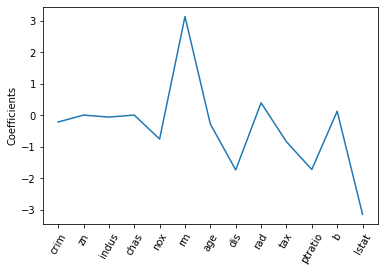

In [51]:
_=plt.plot(range(len(label)),coefficients)
_=plt.xticks(range(len(label)),label,rotation=60)
_=plt.ylabel("Coefficients")
plt.show()

# Data Modelling

## LASSO

### LazyRegressor

In [46]:
from lazypredict.Supervised import LazyRegressor

In [47]:
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )

In [48]:
lasso_df.shape

(415, 12)

In [54]:
xtrain, xtest, ytrain, ytest = train_test_split(lasso_df, labels, test_size=0.2, random_state=75)

In [55]:
models , predictions = reg.fit(xtrain, xtest, ytrain, ytest)
models

100%|██████████| 42/42 [00:04<00:00,  9.79it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.90,0.91,2.38,0.20
GradientBoostingRegressor,0.89,0.91,2.43,0.23
XGBRegressor,0.88,0.90,2.57,0.13
RandomForestRegressor,0.88,0.89,2.62,0.33
HistGradientBoostingRegressor,0.87,0.89,2.70,0.22
BaggingRegressor,0.85,0.87,2.92,0.05
LGBMRegressor,0.84,0.86,2.97,0.07
PoissonRegressor,0.83,0.85,3.09,0.02
KNeighborsRegressor,0.80,0.83,3.33,0.01


### Cross Val Score for SVR, DecisionTreeRegressor, Random Forest 

In [57]:
print('Cross Val Score for Decision Trees: ')
result = cross_val_score(DecisionTreeRegressor(), xtrain, ytrain, cv=5, n_jobs=-1)
print(np.mean(result))

Cross Val Score for Decision Trees: 
0.7548543200096807


In [58]:
print('Cross Val Score for Super Vector Machine: ')
result = cross_val_score(SVR(), xtrain, ytrain, cv=5, n_jobs=-1)
print(np.mean(result))

Cross Val Score for Super Vector Machine: 
0.591648250044811


In [59]:
print('Cross Val Score for Random Forest: ')
result = cross_val_score(RandomForestRegressor(), xtrain, ytrain, cv=5, n_jobs=-1)
print(np.mean(result))

Cross Val Score for Random Forest: 
0.8135730533931917


### RandomForestRegressor

In [61]:
rf2 =  RandomForestRegressor(random_state=0)
rf2.fit(xtrain, ytrain)

y_pred = rf2.predict(xtest)

In [92]:
rf2.score(xtrain, ytrain)

0.9738110272112406

In [64]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ytest, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ytest, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ytest, y_pred)))
mape = np.mean(np.abs((ytest - y_pred) / np.abs(ytest)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))

Mean Absolute Error (MAE): 1.9194698795180722
Mean Squared Error (MSE): 6.358027180722891
Root Mean Squared Error (RMSE): 2.521512875383128
Mean Absolute Percentage Error (MAPE): 9.11
Accuracy: 90.89


In [68]:
lasso_df.columns

Index(['crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat'],
      dtype='object')

In [69]:
feat_impo = pd.Series(rf2.feature_importances_, index=lasso_df.columns).sort_values()

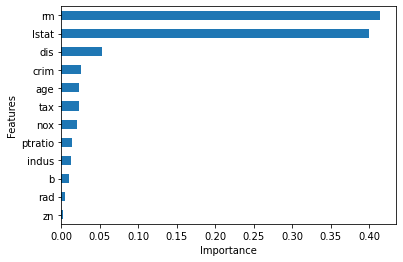

In [70]:
feat_impo.plot(kind="barh")
plt.ylabel('Features')
plt.xlabel('Importance')
plt.show()

In [73]:
columns = []
scores = []

for column in (feat_impo.sort_values(ascending=False).index):
    columns.append(column)
    new_features = df_boston[columns]

    x_train, x_test, y_train, y_test = train_test_split(new_features, labels, test_size=0.15, random_state=42)

    ss = StandardScaler()
    x_train = ss.fit_transform(x_train)

    res = cross_val_score(RandomForestRegressor(), x_train, y_train, cv=5, n_jobs=-1)
    mean = np.mean(res)
    scores.append(mean)

    print(f'Features: {columns}')
    print(mean)

Features: ['rm']
0.3797030406946186
Features: ['rm', 'lstat']
0.7362380326234552
Features: ['rm', 'lstat', 'dis']
0.8170116203701605
Features: ['rm', 'lstat', 'dis', 'crim']
0.830954060076043
Features: ['rm', 'lstat', 'dis', 'crim', 'age']
0.8360232898299375
Features: ['rm', 'lstat', 'dis', 'crim', 'age', 'tax']
0.8397195933807238
Features: ['rm', 'lstat', 'dis', 'crim', 'age', 'tax', 'nox']
0.8433891373716923
Features: ['rm', 'lstat', 'dis', 'crim', 'age', 'tax', 'nox', 'ptratio']
0.8492527612811716
Features: ['rm', 'lstat', 'dis', 'crim', 'age', 'tax', 'nox', 'ptratio', 'indus']
0.8488288666222544
Features: ['rm', 'lstat', 'dis', 'crim', 'age', 'tax', 'nox', 'ptratio', 'indus', 'b']
0.8485596779336386
Features: ['rm', 'lstat', 'dis', 'crim', 'age', 'tax', 'nox', 'ptratio', 'indus', 'b', 'rad']
0.8451554398680339
Features: ['rm', 'lstat', 'dis', 'crim', 'age', 'tax', 'nox', 'ptratio', 'indus', 'b', 'rad', 'zn']
0.8453774829809471


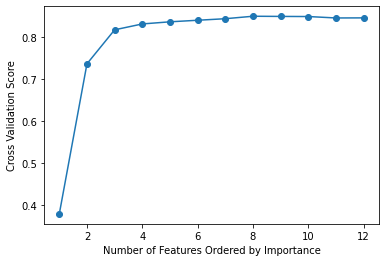

In [74]:
plt.plot(range(1, len(scores)+1), scores, marker='o')
plt.xlabel('Number of Features Ordered by Importance')
plt.ylabel('Cross Validation Score')
plt.show()

In [78]:
new_features = df_boston[['rm', 'lstat', 'dis', 'crim', 'age', 'tax', 'nox', 'ptratio', 'indus', 'b', 'rad', 'zn']]

x_train, x_test, y_train, y_test = train_test_split(new_features, labels, test_size=0.15, random_state=42)

ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.fit_transform(x_test)

model = RandomForestRegressor()
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.8141664002413651

### Hyperparameter Tuning

In [93]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

#List Hyperparameters yang akan diuji
hyperparameters = dict(
                       n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)], # Jumlah subtree 
                       bootstrap = [True], # Apakah pakai bootstrapping atau tidak
                       criterion = ['squared_error', 'friedman_mse', 'poisson', 'absolute_error'],
                       max_depth = [int(x) for x in np.linspace(10, 110, num = 5)],  # Maximum kedalaman tree
                       min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 5)], # Jumlah minimum samples pada node agar boleh di split menjadi leaf baru
                       min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)], # Jumlah minimum samples pada leaf agar boleh terbentuk leaf baru
                       max_features = ['auto', 'sqrt'], # Jumlah feature yg dipertimbangkan pada masing-masing split
                       n_jobs = [-1], # Core untuk parallel computation. -1 untuk menggunakan semua core
                      )

# Init
rf2 = RandomForestRegressor(random_state=0)
rf_tuned = RandomizedSearchCV(rf2, hyperparameters, cv=6, random_state=75, scoring='recall')
rf_tuned.fit(xtrain, ytrain)



# Predict & Evaluation
y_pred1 = rf_tuned.predict(xtest)#Check performa dari model

In [98]:
print(rf_tuned.best_params_)

{'n_jobs': -1, 'n_estimators': 944, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 85, 'criterion': 'friedman_mse', 'bootstrap': True}


In [106]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ytest, y_pred1))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ytest, y_pred1))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ytest, y_pred1)))
mape = np.mean(np.abs((ytest - y_pred1) / np.abs(ytest)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('R2:', round(100*(1 - mape), 2))

Mean Absolute Error (MAE): 2.2091753535255476
Mean Squared Error (MSE): 8.8943539958966
Root Mean Squared Error (RMSE): 2.9823403554753103
Mean Absolute Percentage Error (MAPE): 10.26
R2: 89.74


In [95]:
from sklearn.model_selection import GridSearchCV
param_grid1 = {'n_estimators': [522], 'min_samples_split': [6], 'min_samples_leaf': [1], 'max_features': ['sqrt'], 'max_depth': [60], 'criterion': ['squared_error', 'friedman_mse', 'poisson', 'absolute_error'], 'bootstrap': [True]}

rfr = RandomForestRegressor()

g_search = GridSearchCV(estimator = rfr, param_grid = param_grid1, cv=3,n_jobs = 1, verbose = 0, return_train_score=True)
g_search.fit(xtrain, ytrain);
y_pred2 = g_search.predict(xtest)#Check performa dari model

In [96]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ytest, y_pred2))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ytest, y_pred2))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ytest, y_pred2)))
mape = np.mean(np.abs((ytest - y_pred2) / np.abs(ytest)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))

Mean Absolute Error (MAE): 2.071159731208028
Mean Squared Error (MSE): 7.796292734212352
Root Mean Squared Error (RMSE): 2.7921842228284923
Mean Absolute Percentage Error (MAPE): 9.61
Accuracy: 90.39


In [99]:
print(g_search.best_params_)

{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 522}
